# Read files

In [18]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
# colors:
syren_linear_cmap = LinearSegmentedColormap.from_list("syrencmap", [(1, 1, 1), (.3,0,.5)])

syren_listed_cmap =  ListedColormap([(.7, 0, .1), (1, .6, 0), (.6,.8,1), (.3,0,.5), (0, .2, .4)]);

In [19]:
def split_by_benchmark(benchmarks_results: list[dict]):
    results_by_benchmark: dict[str, list[dict]] = {}
    for result in benchmarks_results:
        if result['benchmark'] not in results_by_benchmark:
            results_by_benchmark[result['benchmark']] = []
        results_by_benchmark[result['benchmark']].append(result)

    return results_by_benchmark

In [20]:
timeout = 10 * 60  # 10min

scorings = [r"\(\chi_{\mathrm{syn}}\)", r"\(\chi_{\mathrm{T}}\)"]
algos = [r"\(\mathcal{A}\)", r"\textsc{RTS}", r"\(k\)-search"]

def change_synth_times_format(benchmarks_results):
    for result in benchmarks_results:
        if 'synth_times' not in result:
            result['synth_times'] = {}
        if 'minimal' not in result:
            result['minimal'] = {}
        i = 1
        for scoring in scorings:
            for algo in algos:
                if result[f't{i}'] == 'TO':
                    result['minimal'][(scoring, algo)] = False
                    result['synth_times'][(scoring, algo)] = float('inf')
                elif result[f't{i}'][0] == '(':
                    result['minimal'][(scoring, algo)] = False
                    result['synth_times'][(scoring, algo)] = eval(result[f't{i}'])
                else:
                    result['minimal'][(scoring, algo)] = True
                    result['synth_times'][(scoring, algo)] = eval(result[f't{i}'])
                del result[f't{i}']
                i += 1
    return benchmarks_results

# Cactus plots

In [21]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.serif": "Libertine",
    "font.size": 26,
    'lines.linewidth': 2
})


def default_cactus_plot(plt, benchmarks_results):
    plt.gca().set_aspect('auto')
    plt.xlabel("Synthesis time")
    plt.xscale('log')
    plt.xlim(0.007, timeout)
    plt.xticks([.01, .1, 1, 10, 60, 60 * 5], [".01", ".1s", "1s", "10s", "1m", "5m"])

    plt.ylabel("Instances solved")
    plt.ylim(0, len(benchmarks_results))
    plt.yticks(range(0, len(benchmarks_results), 10), range(0, len(benchmarks_results), 10))

    plt.legend()
    plt.grid(visible=True, color='#ddddee')
    plt.set_cmap(syren_listed_cmap)


In [22]:
import matplotlib
def plot_cactus_comparing_algos(benchmarks_results):
    # set line colors:
    matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=syren_listed_cmap.colors)
    
    for scoring in scorings[:1]:
        for algo in algos:
            cactus = [(0, 0)]
            cactus_ct = 0
            # sort results by synth time for this score function and search algorithm
            sorted_results = sorted(benchmarks_results, key=lambda r: r['synth_times'][(scoring, algo)])
            for result in sorted_results:
                # only plot if Syren found the optimal solution
                if result['minimal'][(scoring, algo)]:
                    cactus_ct += 1
                    cactus.append((result['synth_times'][(scoring, algo)], cactus_ct))

            plt.plot([c[0] for c in cactus], [c[1] for c in cactus], label=f"{algo}")

    default_cactus_plot(plt, benchmarks_results)
    # plt.title(r"Instances solved per search algorithm")
    plt.savefig("cactus_algos.pdf", bbox_inches='tight')
    plt.show()
    plt.clf()

## Make plots:

54 results read


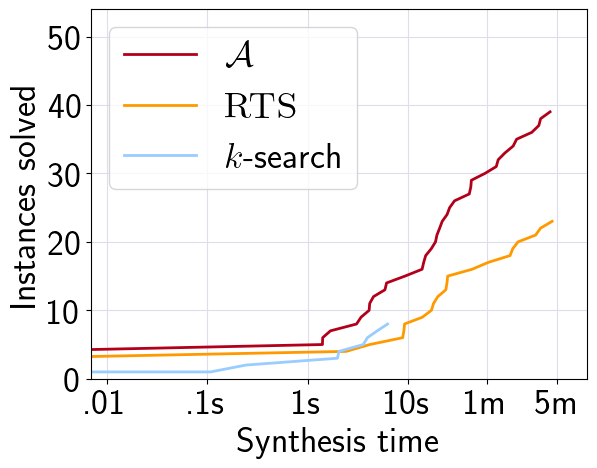

<Figure size 640x480 with 0 Axes>

In [23]:
import csv

benchmarks_results: list[dict] = []
with open("benchmarks.csv") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        benchmarks_results.append(row)
print(f"{len(benchmarks_results)} results read")
benchmarks_results = change_synth_times_format(benchmarks_results)
# benchmarks_results['synth_times']: float shows the synthesis times
# benchmarks_results['minimal']: bool shows whether the synthesized solution is optimal

# print(benchmarks_results[0])

plot_cactus_comparing_algos(benchmarks_results)


# Minimality of solution plots

54 results read


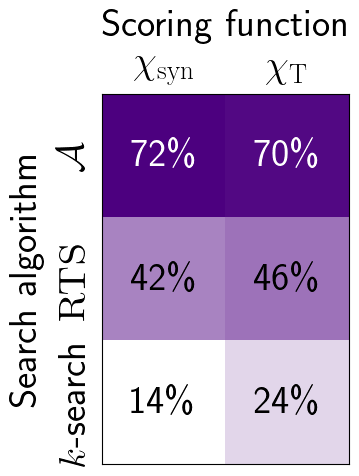

<Figure size 640x480 with 0 Axes>

In [24]:

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.serif": "Libertine",
    "font.size": 28,
    'lines.linewidth': 2
})

benchmarks_results: list[dict] = []
with open("benchmarks.csv") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        benchmarks_results.append(row)
print(f"{len(benchmarks_results)} results read")
benchmarks_results = change_synth_times_format(benchmarks_results)

minimal_cts = [[0 for _ in range(len(scorings))] for _ in range(len(algos))]
total_cts = [[0 for _ in range(len(scorings))] for _ in range(len(algos))]
labels = [["" for _ in range(len(scorings))] for _ in range(len(algos))]
for result in benchmarks_results:
    for j, algo in enumerate(algos):
        for i, scoring in enumerate(scorings):
            if result['minimal'][(scoring, algo)]:
                minimal_cts[j][i] += 1
            total_cts[j][i] += 1

data = np.array(minimal_cts) / np.array(total_cts)
for i, algo in enumerate(algos):
    for j, scoring in enumerate(scorings):
        plt.text(j, i, fr'{int(data[i, j] * 100)}\%', ha="center", va="center", color='w' if data[i, j] > 0.55 else 'k')

plt.xticks(range(len(scorings)), scorings)
plt.yticks(range(len(algos)), algos, va='center', rotation=90)
plt.imshow(data, cmap=syren_linear_cmap)
plt.tick_params(axis='x', labelbottom=False, labeltop=True, bottom=False)
plt.tick_params(axis='y', left=False, labelrotation=90)
# plt.axes().xaxis.set_label_position('top')
plt.title("Scoring function", size=28, pad=10)
plt.ylabel("Search algorithm", size=28, rotation=90, labelpad=10)
plt.savefig("minimality.pdf", bbox_inches='tight')
plt.show()
plt.clf()

# Benchmark complexity stats    

In [25]:
benchmarks_results: list[dict] = []
with open("benchmarks.csv") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        benchmarks_results.append(row)
print(f"{len(benchmarks_results)} results read")
benchmarks_results = change_synth_times_format(benchmarks_results)

54 results read


## heatmap

[[0.875, 0.8333333333333334, 0.75, 1.0], [0.0, 0.7692307692307693, 0.8, 0], [1.0, 1.0, 0.6666666666666666, 0.0], [0, 0, 0, 0.0]]
[['7/8', '10/12', '3/4', '1/1'], ['0/1', '10/13', '4/5', '-'], ['1/1', '1/1', '2/3', '0/1'], ['-', '-', '-', '0/3']]


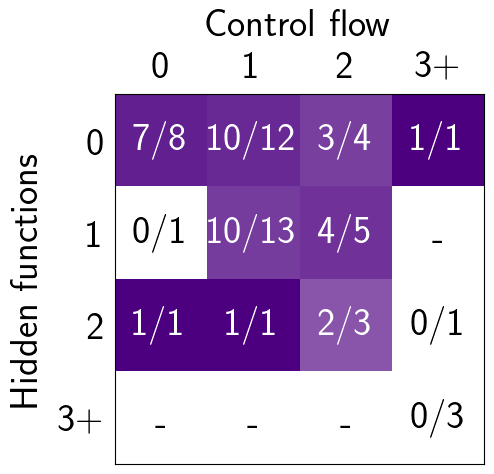

<Figure size 640x480 with 0 Axes>

In [26]:
num_cats = 4

def plot_imshow(color_values, string_values, filename):
    for i in range(len(string_values)):
        for j in range(len(string_values[0])):
            plt.text(
                j, i,
                string_values[i][j],
                ha="center", va="center",
                color='w' if color_values[i][j] > .5 * max(max(v for v in row) for row in color_values) else 'k')

    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.serif": "Libertine",
        "font.size": 22,
        "lines.linewidth": 2
    })

    plt.imshow(color_values, cmap=syren_linear_cmap)
    plt.xticks(range(num_cats), [str(i) for i in range(num_cats-1)] + [str(num_cats-1)+"+"])
    plt.yticks(range(num_cats), [str(i) for i in range(num_cats-1)] + [str(num_cats-1)+"+"])
    plt.tick_params(axis='x', labelbottom=False, labeltop=True, bottom=False)
    plt.tick_params(axis='y', left=False)
    plt.title("Control flow", size=28, pad=10)
    plt.ylabel("Hidden functions", size=28, rotation=90, labelpad=10)
    plt.savefig(filename, bbox_inches='tight')
    plt.show()
    plt.clf()


totals_dict = {}
solved_dict = {}
for r in benchmarks_results:
    control_flow_ct = 0
    for stat in ['conds', 'loops']:
        num_stats = r[stat]
        if num_stats == '??' or num_stats == 'TO':
            # num_stats is '??' or 'TO' if the benchmark is not supported by our dsl.
            continue
        control_flow_ct += eval(num_stats)
    if r['dataf'] == '??' or r['dataf'] == 'TO':
        continue
    dataf_ct = eval(r['dataf'])
    # the next line counts terminated instances
    # solved = r['synth_times'][(scorings[0], algos[0])] != float('inf')
    # the next line counts correct synthesized instances
    solved = r['minimal'][(scorings[0], algos[0])]

    #merge 2+ together
    if control_flow_ct >= num_cats-1:
        control_flow_ct = f'{num_cats-1}+'
    if dataf_ct >= num_cats-1:
        dataf_ct = f"{num_cats-1}+"

    if (control_flow_ct, dataf_ct) not in totals_dict:
        totals_dict[(control_flow_ct, dataf_ct)] = 0
    totals_dict[(control_flow_ct, dataf_ct)] += 1

    if solved:
        if (control_flow_ct, dataf_ct) not in solved_dict:
            solved_dict[(control_flow_ct, dataf_ct)] = 0
        solved_dict[(control_flow_ct, dataf_ct)] += 1

heat_data_str = [[0 for _ in range(num_cats)] for _ in range(num_cats)]
heat_data_solved_vals = [[0 for _ in range(num_cats)] for _ in range(num_cats)]
heat_data_total_vals = [[0 for _ in range(num_cats)] for _ in range(num_cats)]
for cf_idx in range(num_cats):
    for df_idx in range(num_cats):
        if cf_idx == num_cats-1:
            cf_k = f'{num_cats-1}+'
        else:
            cf_k = cf_idx
        if df_idx == num_cats-1:
            df_k = f'{num_cats-1}+'
        else:
            df_k = df_idx
        if (cf_k, df_k) not in solved_dict:
            solved_dict[(cf_k, df_k)] = 0
        if (cf_k, df_k) not in totals_dict:
            totals_dict[(cf_k, df_k)] = 0

        if totals_dict[(cf_k, df_k)] > 0:
            heat_data_str[cf_idx][df_idx] = str(round(100 * solved_dict[(cf_k, df_k)] / totals_dict[(cf_k, df_k)])) + r'\%'
            heat_data_solved_vals[cf_idx][df_idx] = solved_dict[(cf_k, df_k)] / totals_dict[(cf_k, df_k)]
        else:
            heat_data_str[cf_idx][df_idx] = '--'
            heat_data_solved_vals[cf_idx][df_idx] = 0
        heat_data_total_vals[cf_idx][df_idx] = "-" if totals_dict[(cf_k, df_k)] == 0 else f"{solved_dict[(cf_k, df_k)]}/{totals_dict[(cf_k, df_k)]}"

print(heat_data_solved_vals)
print(heat_data_total_vals)

# plot_imshow(heat_data_solved_vals, heat_data_str, "solved_complexity1.pdf")
# plot_imshow(heat_data_total_vals, heat_data_str, "solved_complexity2.pdf")
plot_imshow(heat_data_solved_vals, heat_data_total_vals, "solved_complexity3.pdf")
